In [181]:
import math
import random
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
sns.set_palette("bright")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load Data

In [5]:
breast_cancer = load_breast_cancer()
print(breast_cancer['DESCR'])

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

# Process Data

In [15]:
df_bc = pd.DataFrame(breast_cancer['data'], columns=breast_cancer['feature_names'])
df_bc['target'] = breast_cancer['target'] # target cancer type - malignant/benign (1/0)

print(f'Dataset size: {df_bc.shape}')
df_bc.head()

Dataset size: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [12]:
df_bc['target'].value_counts() / len(df_bc) * 100

1    62.741652
0    37.258348
Name: target, dtype: float64

This means roughly 62.7% cases are malignant and 37.3% are benign.

In [17]:
# Split dataframe into train and test
df_train, df_test = train_test_split(df_bc, test_size=0.2, random_state=42, stratify=df_bc['target'])
df_train = df_train.reset_index()
df_test = df_test.reset_index()
print(f'Size of train set: {df_train.shape}')
print(f'Size of test set: {df_test.shape}')

Size of train set: (455, 32)
Size of test set: (114, 32)


In [18]:
# Check distribution of class labels in train set
df_train['target'].value_counts() / len(df_train) * 100

1    62.637363
0    37.362637
Name: target, dtype: float64

In [19]:
# Check distribution of class labels in test set
df_test['target'].value_counts() / len(df_test) * 100

1    63.157895
0    36.842105
Name: target, dtype: float64

In [22]:
# Distribution of train
df_train.describe()

,index,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,276.654945,14.067213,19.247363,91.557407,648.541099,0.096167,0.103869,0.089193,0.048344,0.180618,...,25.647297,106.625297,869.026593,0.132329,0.254329,0.276578,0.113904,0.290865,0.083945,0.626374
std,164.998497,3.499380,4.405291,24.149231,344.944564,0.013458,0.053522,0.081747,0.038925,0.028074,...,6.225470,33.195053,552.926912,0.022550,0.159882,0.215937,0.066784,0.064624,0.018408,0.484299
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,132.500000,11.635000,16.000000,74.720000,415.650000,0.086475,0.063750,0.028010,0.020220,0.161750,...,21.090000,83.715000,513.900000,0.115950,0.145850,0.107900,0.063390,0.249400,0.071835,0.000000
50%,276.000000,13.270000,18.820000,85.980000,541.800000,0.095660,0.090970,0.059990,0.032630,0.178100,...,25.400000,97.590000,683.400000,0.131400,0.211600,0.229800,0.097220,0.281900,0.079930,1.000000
75%,418.500000,15.740000,21.710000,103.700000,770.050000,0.104850,0.130100,0.132200,0.073820,0.195300,...,29.370000,124.950000,1033.500000,0.146200,0.336800,0.385300,0.162500,0.320100,0.092070,1.000000
max,566.000000,28.110000,39.280000,188.500000,2499.000000,0.144700,0.345400,0.426800,0.201200,0.304000,...,49.540000,229.300000,3432.000000,0.218400,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [23]:
# Distribution of train
df_test.describe()

,index,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,...,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,313.315789,14.367079,19.458421,93.611930,680.225439,0.097130,0.106225,0.087227,0.051215,0.183332,...,25.796667,109.799298,926.707895,0.132527,0.254011,0.254668,0.117408,0.286924,0.083951,0.631579
std,159.345304,3.626623,3.870388,24.928082,379.002396,0.016305,0.050065,0.071367,0.038397,0.024598,...,5.844268,35.218674,631.217286,0.024028,0.147410,0.176207,0.061556,0.049475,0.016683,0.484506
min,1.000000,7.760000,11.970000,47.920000,181.000000,0.052630,0.031160,0.000000,0.000000,0.135300,...,14.100000,59.160000,268.600000,0.088640,0.052320,0.000000,0.000000,0.199900,0.059330,0.000000
25%,200.750000,11.890000,16.685000,76.375000,434.250000,0.085377,0.067132,0.039090,0.022295,0.164250,...,21.022500,85.075000,515.950000,0.120025,0.148600,0.121400,0.073853,0.253150,0.071180,0.000000
50%,307.500000,13.680000,19.025000,87.910000,571.450000,0.096870,0.097620,0.066940,0.041650,0.184350,...,25.430000,98.790000,693.300000,0.131200,0.217700,0.210650,0.109550,0.282250,0.080535,1.000000
75%,450.250000,16.245000,21.922500,106.525000,811.050000,0.107500,0.131525,0.117375,0.073072,0.197375,...,30.377500,128.425000,1145.000000,0.145450,0.342350,0.375800,0.157000,0.307475,0.092165,1.000000
max,568.000000,27.420000,29.330000,186.900000,2501.000000,0.163400,0.277000,0.363500,0.187800,0.259500,...,41.850000,251.200000,4254.000000,0.222600,0.868100,0.938700,0.268800,0.475300,0.143100,1.000000


# Baseline Models

1. Random classifier
2. Majority class classifier

In [147]:
random_cls_proba = [random.random() for _ in range(len(df_test))]

In [148]:
majority_class = df_train['target'].value_counts().index[0]

In [149]:
# Augment test dataframe with baseline model results
df_test['baseline_1_proba'] = random_cls_proba
df_test['baseline_1'] = df_test['baseline_1_proba'].apply(lambda x: 1 if x > 0.5 else 0)
df_test['baseline_2'] = majority_class

# Random Forest Classifier

In [110]:
print(f"Number of features: {len(breast_cancer['feature_names'])}")

Number of features: 30


In [111]:
X_train = df_train[breast_cancer['feature_names']]
X_test = df_test[breast_cancer['feature_names']]
y_train = df_train[['target']].values

In [125]:
# Perform grid search to determine 'optimum' hyperparameters
model_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                                 ('pca', PCA(random_state=42)), 
                                 ('rf_cls', RandomForestClassifier(random_state=42, n_jobs=4))])

# n_components = [2, 4, 8, 10, 13] # round 1
# n_estimators = [10, 50, 100, 1000] # round 1
# criteria = ['gini', 'entropy'] # round 1
# max_depths = [None, 10, 100, 1000] # round 1

# n_components = [8, 9, ] # round 2
# n_estimators = np.arange(500, 1501, 100) # round 2
# criteria = ['entropy', ] # round 2
# max_depths = [None, ] # round 2

n_components = [8, ] # round 3
n_estimators = np.arange(950, 1051, 10) # round 3
criteria = ['entropy', ] # round 3
max_depths = [None, ] # round 3

estimator  = GridSearchCV(model_pipeline, cv=5, n_jobs=4, verbose=5, param_grid=dict(
                                        pca__n_components=n_components,
                                        rf_cls__n_estimators=n_estimators,
                                        rf_cls__criterion=criteria,
                                        rf_cls__max_depth=max_depths))
estimator.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   18.4s
[Parallel(n_jobs=4)]: Done  55 out of  55 | elapsed:  1.4min finished
C:\Users\ajthampi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('rf_cls', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
        ...stimators=10, n_jobs=4,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'pca__n_components': [8], 'rf_cls__n_estimators': array([ 950,  960,  970,  980,  990, 1000, 1010, 1020, 1030, 1040, 1050]), 'rf_cls__criterion': ['entropy'], 'rf_cls__max_depth': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [126]:
# round 1: {'pca__n_components': 8, 'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': None, 'rf_cls__n_estimators': 1000}
# round 2: {'pca__n_components': 8, 'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': None, 'rf_cls__n_estimators': 1000}
# round 3: {'pca__n_components': 8, 'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': None, 'rf_cls__n_estimators': 970}
estimator.best_params_ 

{'pca__n_components': 8,
 'rf_cls__criterion': 'entropy',
 'rf_cls__max_depth': None,
 'rf_cls__n_estimators': 970}

In [127]:
best_model = estimator.best_estimator_

In [134]:
y_test = best_model.predict(X_test)
y_proba_test = best_model.predict_proba(X_test)

In [137]:
df_test['rf_cls'] = y_test
df_test['rf_cls_proba'] = y_proba_test[:,1]

# Evaluate Model Performance

In [159]:
def normalise_cm(cm):
    return cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [214]:
def plot_confusion_matrix(cm, classes, filename,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = normalise_cm(cm)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(filename, dpi=200, bbox_inches='tight')

In [161]:
b1_cm = confusion_matrix(df_test['target'], df_test['baseline_1'])
b2_cm = confusion_matrix(df_test['target'], df_test['baseline_2'])
rf_cm = confusion_matrix(df_test['target'], df_test['rf_cls'])
b1_cm_norm = normalise_cm(b1_cm)
b2_cm_norm = normalise_cm(b2_cm)
rf_cm_norm = normalise_cm(rf_cm)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[ 1 -2]
 [-4  1]]


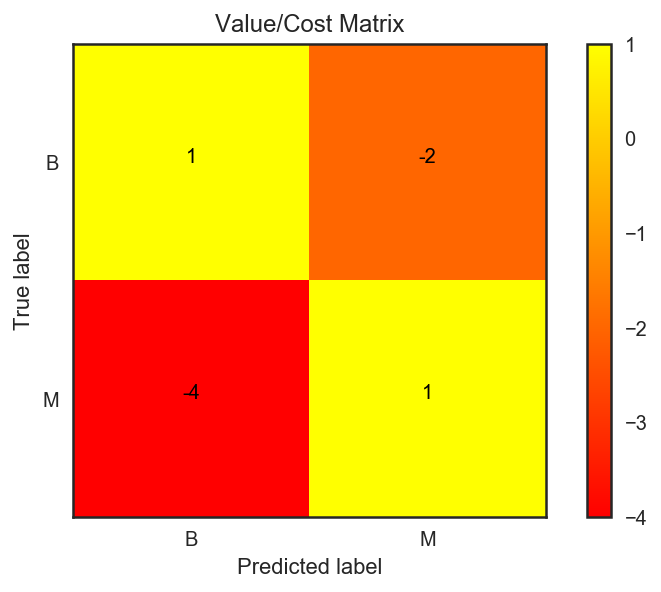

In [215]:
value_cost_matrix = np.array([[1, -2], [-4, 1]])
plot_confusion_matrix(value_cost_matrix, classes=['B', 'M'], 
                      filename='images/value_cost_matrix.png',
                      title='Value/Cost Matrix',
                      cmap=plt.cm.autumn)

Normalized confusion matrix
[[0.45 0.55]
 [0.54 0.46]]


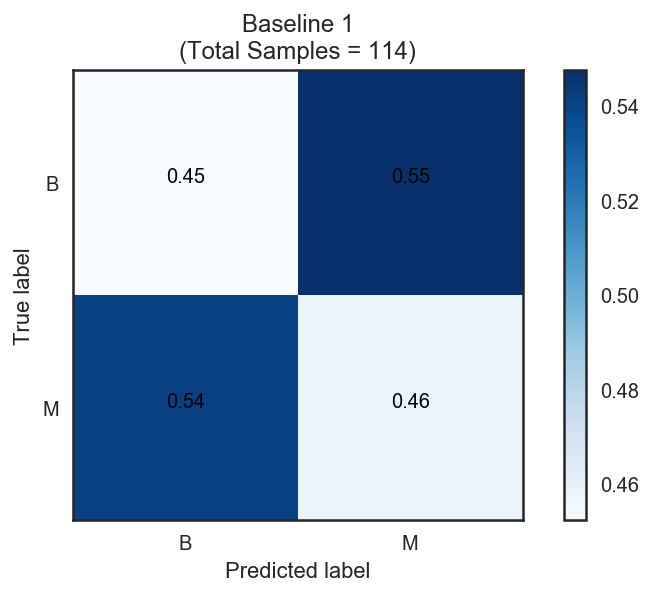

In [216]:
plot_confusion_matrix(b1_cm, classes=['B', 'M'], 
                      filename='images/baseline_1_cm.png',
                      title=f'Baseline 1\n(Total Samples = {len(df_test)})', 
                      normalize=True)

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


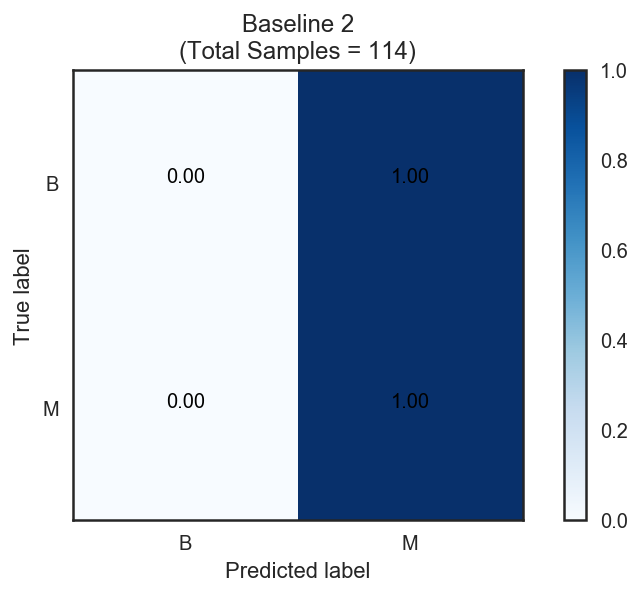

In [217]:
plot_confusion_matrix(b2_cm, classes=['B', 'M'], 
                      filename='images/baseline_2_cm.png',
                      title=f'Baseline 2\n(Total Samples = {len(df_test)})', 
                      normalize=True)

Normalized confusion matrix
[[0.9  0.1 ]
 [0.07 0.93]]


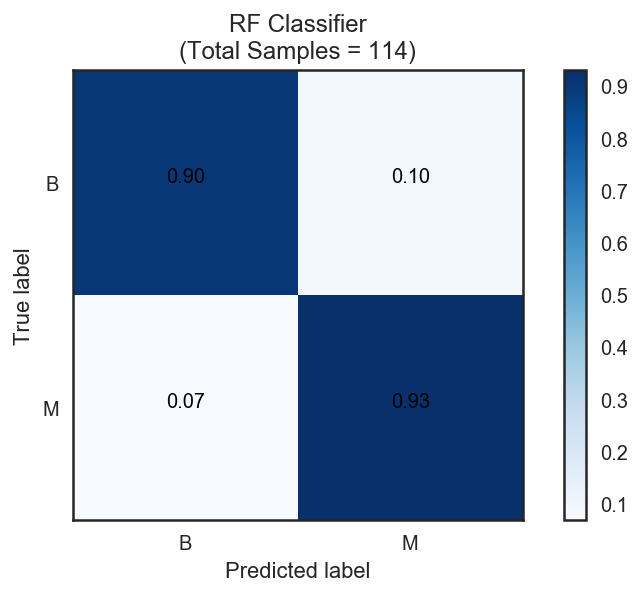

In [218]:
plot_confusion_matrix(rf_cm, classes=['B', 'M'], 
                      filename='images/rf_cls_cm.png',
                      title=f'RF Classifier\n(Total Samples = {len(df_test)})', 
                      normalize=True)

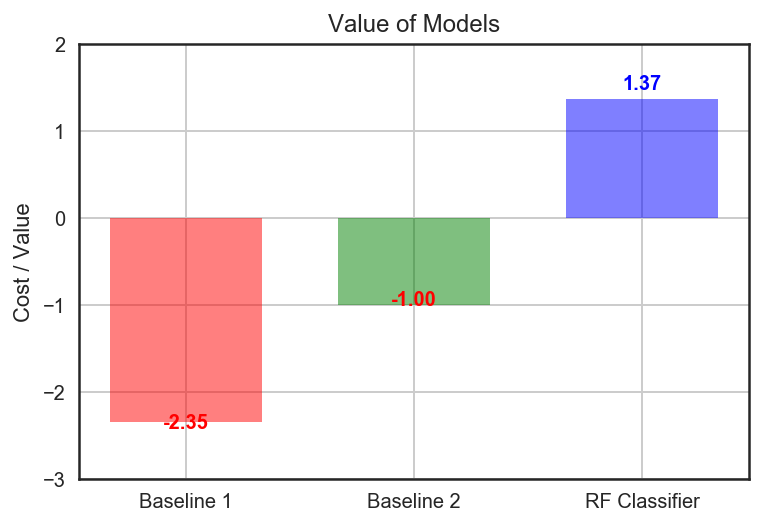

In [302]:
# Function to compute value given unnormalised confusion matrix (cm) and value-cost matrix (vcm)
compute_value = lambda cm, vcm: normalise_cm(cm).flatten().dot(vcm.flatten())

b1_value = compute_value(b1_cm, value_cost_matrix)
b2_value = compute_value(b2_cm, value_cost_matrix)
rf_value = compute_value(rf_cm, value_cost_matrix)

f, ax = plt.subplots()
def autolabel(rect, color='blue'):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            '%.2f' % height,
            ha='center', va='bottom', color=color, fontweight='bold')

x = [0, 0.3, 0.6]
y = [b1_value, b2_value, rf_value]
rect_b1, rect_b2, rect_rf = ax.bar(x, y, alpha=0.5, width=0.2)
rect_b1.set_facecolor('r')
rect_b2.set_facecolor('g')
rect_rf.set_facecolor('b')

autolabel(rect_b1, color='red')
autolabel(rect_b2, color='red')
autolabel(rect_rf, color='blue')
ax.set_ylim([-3, 2])

ax.set_xticks(x)
ax.set_xticklabels(['Baseline 1', 'Baseline 2', 'RF Classifier'])
ax.grid(True)
ax.set_ylabel('Cost / Value')
ax.set_title('Value of Models')
f.savefig('images/value_cost_models.png', dpi=200, bbox_inches='tight');

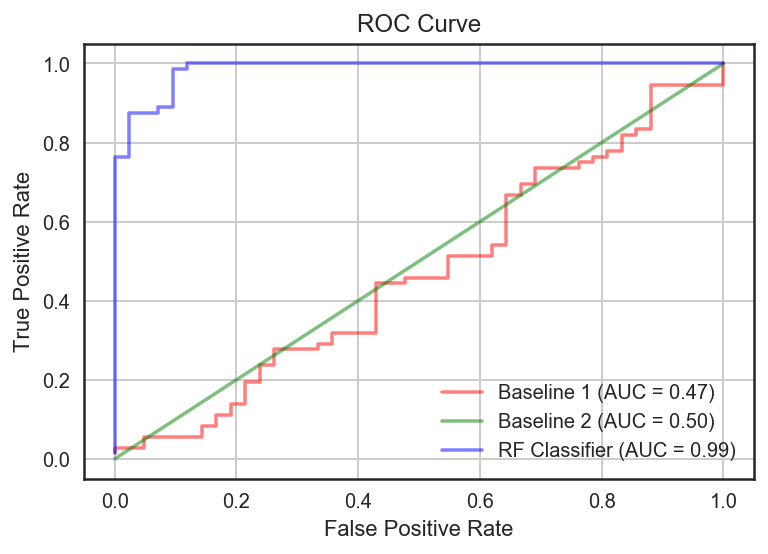

In [219]:
b1_fpr, b1_tpr, b1_roc_th = roc_curve(df_test['target'], df_test['baseline_1_proba'])
b2_fpr, b2_tpr, b2_roc_th = roc_curve(df_test['target'], df_test['baseline_2'])
rf_fpr, rf_tpr, rf_roc_th = roc_curve(df_test['target'], df_test['rf_cls_proba'])
f, ax = plt.subplots()
ax.plot(b1_fpr, b1_tpr, 'r-', alpha=0.5, label='Baseline 1 (AUC = %.2f)' % auc(b1_fpr, b1_tpr))
ax.plot(b2_fpr, b2_tpr, 'g-', alpha=0.5, label='Baseline 2 (AUC = %.2f)' % auc(b2_fpr, b2_tpr))
ax.plot(rf_fpr, rf_tpr, 'b-', alpha=0.5, label='RF Classifier (AUC = %.2f)' % auc(rf_fpr, rf_tpr))
ax.grid(True)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend()
f.savefig('images/roc_auc.png', dpi=200, bbox_inches='tight');

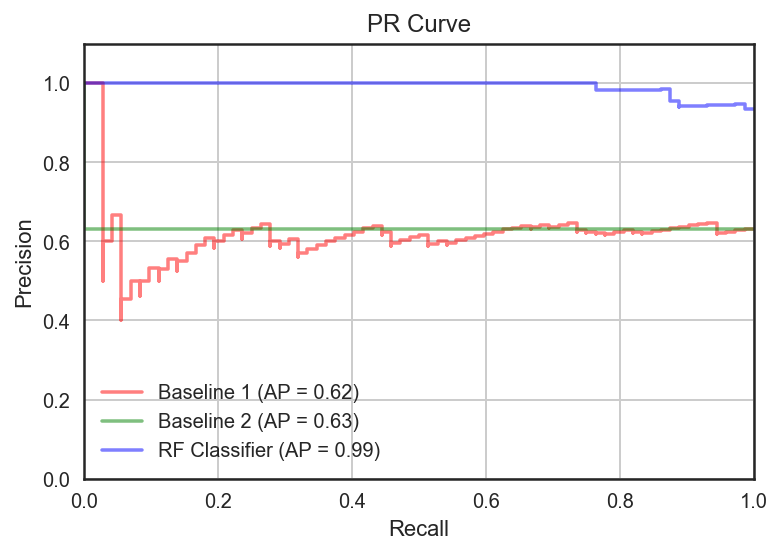

In [221]:
b1_p, b1_r, b1_pr_th = precision_recall_curve(df_test['target'], df_test['baseline_1_proba'])
b1_ap = average_precision_score(df_test['target'], df_test['baseline_1_proba'])
b2_p, b2_r, b2_pr_th = precision_recall_curve(df_test['target'], df_test['baseline_2'])
b2_ap = average_precision_score(df_test['target'], df_test['baseline_2'])
rf_p, rf_r, rf_pr_th = precision_recall_curve(df_test['target'], df_test['rf_cls_proba'])
rf_ap = average_precision_score(df_test['target'], df_test['rf_cls_proba'])
f, ax = plt.subplots()
ax.step(b1_r, b1_p, 'r-', alpha=0.5, label='Baseline 1 (AP = %.2f)' % b1_ap, where='post')
ax.step(b2_r, b2_p, 'g-', alpha=0.5, label='Baseline 2 (AP = %.2f)' % b2_ap, where='post')
ax.step(rf_r, rf_p, 'b-', alpha=0.5, label='RF Classifier (AP = %.2f)' % rf_ap, where='post')
ax.grid(True)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('PR Curve')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.1])
ax.legend()
f.savefig('images/pr_curve.png', dpi=200, bbox_inches='tight');

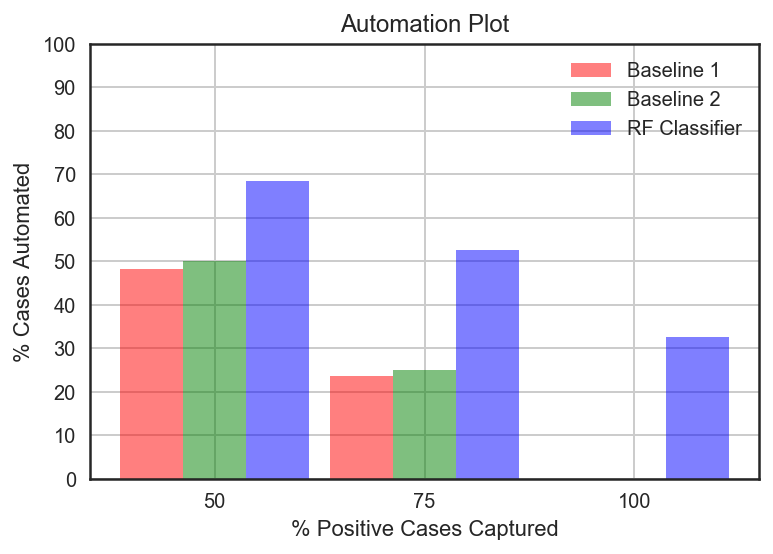

In [303]:
malignant_rate = len(df_test[df_test['target'] == 1]) / len(df_test) * 100
recalls_to_consider = [0.5, 0.75, 1.0]

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx
x = []
b1_auto = []
b2_auto = []
rf_auto = []
for recall in recalls_to_consider:
    x.append(int(recall * 100))
    b1_auto.append(100 - malignant_rate * recall / b1_p[find_nearest(b1_r, recall)[1]])
    b2_auto.append(100 - malignant_rate * recall / b2_p[find_nearest(b2_r, recall)[1]])
    rf_auto.append(100 - malignant_rate * recall / rf_p[find_nearest(rf_r, recall)[1]])

f, ax = plt.subplots()
index = np.arange(len(x))
bar_width = 0.3
opacity = 0.5
ax.bar(index, b1_auto, bar_width,
       alpha=opacity, color='r',
       label='Baseline 1')
ax.bar(index + bar_width, b2_auto, bar_width,
       alpha=opacity, color='g',
       label='Baseline 2')
ax.bar(index + 2 * bar_width, rf_auto, bar_width,
       alpha=opacity, color='b',
       label='RF Classifier')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(x)
ax.set_ylim([0, 100])
ax.set_yticks(np.arange(0, 101, 10))
ax.set_ylabel('% Cases Automated')
ax.set_xlabel('% Positive Cases Captured')
ax.grid(True)
ax.legend()
ax.set_title('Automation Plot')
f.savefig('images/automation.png', dpi=200, bbox_inches='tight');